In [1]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../codes')

In [4]:
from VMSfunctions.model import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *

### Generates Empirical Data

Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [5]:
ps = load_obj('../models/peak_sampler_4_beers.p')

Load chromatogram data exported from R

In [6]:
xcms_output = '../models/beer_ms1_peaks.csv.gz'
min_ms1_intensity = 2E5
min_rt = 3*60
max_rt = 21*60
cl = ChromatogramLoader(xcms_output, min_ms1_intensity, min_rt, max_rt)

Processing exported chromatograms
0


../codes\VMSfunctions\Common.py:49: RuntimeWarning:

divide by zero encountered in double_scalars



5000
10000
15000
20000
25000
30000
35000
40000
45000
Loaded 24002 UnknownChemicals/Chromatograms


Creates a liquid chromatography column, with 3 `KnownChemical`.

In [7]:
# formula_strings = ['C8H10N4O2', 'C6H9N3O2', 'C5H9NO2']
# column = KnownColumn('LC', formula_strings, ps)

Creates a liquid chromatography column, with 10 `UnknownChemical`.

In [8]:
num_chemicals = 1000
column = UnknownColumn('LC', num_chemicals, ps, cl)

Plot some chemicals

UnknownChemical mz=292.2890 rt=1005.61 max_intensity=1.00


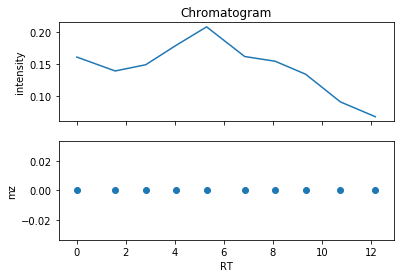

UnknownChemical mz=139.2632 rt=278.08 max_intensity=1.00


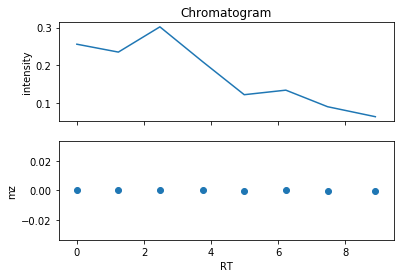

UnknownChemical mz=293.3818 rt=412.66 max_intensity=1.00


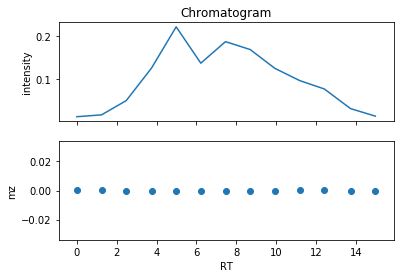

UnknownChemical mz=226.9202 rt=255.44 max_intensity=1.00


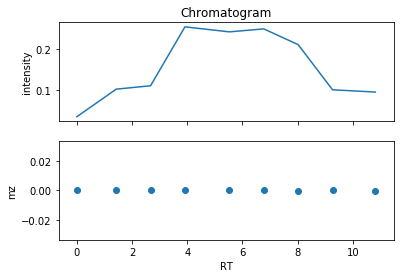

UnknownChemical mz=194.7726 rt=490.51 max_intensity=1.00


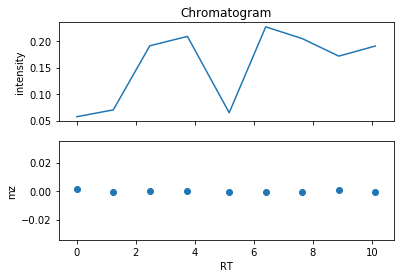

UnknownChemical mz=303.2793 rt=374.50 max_intensity=1.00


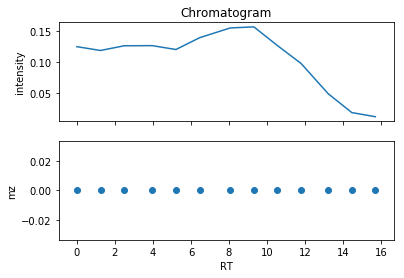

UnknownChemical mz=127.8355 rt=552.88 max_intensity=1.00


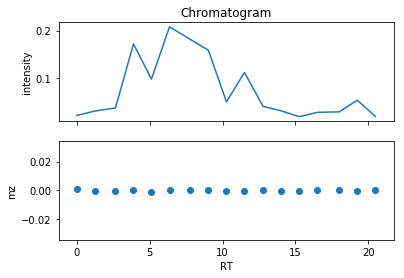

UnknownChemical mz=303.5202 rt=877.30 max_intensity=1.00


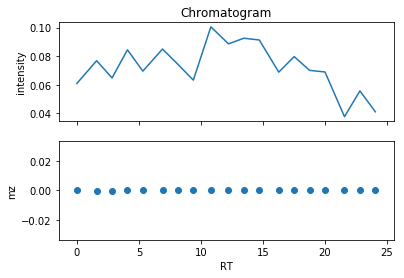

UnknownChemical mz=523.2385 rt=1041.53 max_intensity=1.00


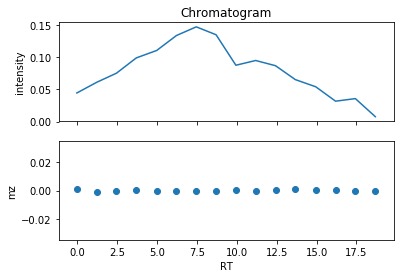

UnknownChemical mz=238.1318 rt=1244.00 max_intensity=1.00


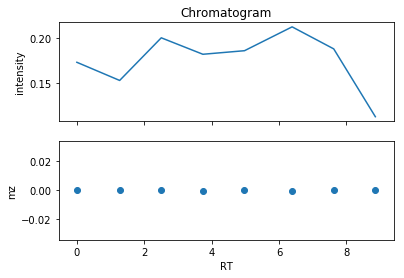

In [9]:
def plot_chromatogram(chrom):
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(chrom.rts, chrom.intensities)
    axarr[0].set_title('Chromatogram')
    axarr[0].set_ylabel('intensity')
    axarr[1].scatter(chrom.rts, chrom.mzs)
    axarr[1].set_ylabel('mz')
    axarr[1].set_xlabel('RT')    
    plt.show()

for chem in column.chemicals[0:10]:
    print(chem)
    plot_chromatogram(chem.chromatogram)

Connect the column to mass spec. Define the scan times, scan_levels and isolation windows.

In [10]:
scan_times = np.arange(0, 1000)+1
scan_levels = np.zeros_like(scan_times)
scan_levels.fill(1)
isolation_windows = [[(0, 1e3)]]

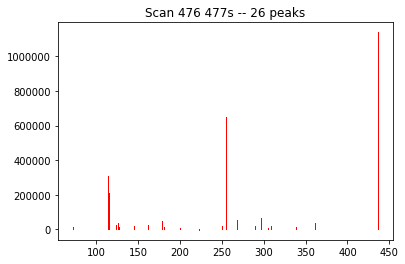

72.34748232049715 13218.661319218638
113.5846599387794 310429.9507293538
114.89031719516099 207947.19372421378
123.56457511368006 27045.282886325567
126.0748711803114 34812.06728555858
127.40623438356965 12108.728080117937
144.58150715203365 20194.377550008707
153.6835794902275 923.541096656203
157.39878890600514 3563.711825550681
161.9638644363718 22678.831916875137
166.53672321997638 3464.00410968834
178.84921443862365 47397.09081812342
180.43183114856183 11075.136956045424
200.38516826009513 6254.794489122252
223.06000646526118 -3585.857357803369
250.44472379959612 17868.368483329097
254.33070163034446 648760.7187308227
268.18995272937167 53451.455613757535
278.66683837630217 4419.575208860013
289.1153882501406 17142.286246497722
296.214273227236 67990.07414006702
305.0021153690496 6168.30560458288
308.30016350003825 21456.698772170603
338.02069312977187 12604.97681742494
360.9828675968122 34736.930109054345
436.1160709597468 1139810.6615636835


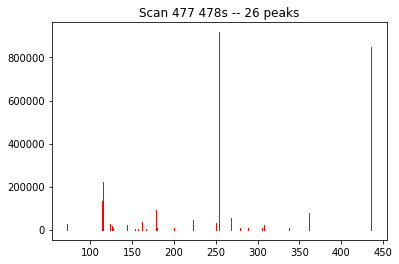

72.34783695053089 25919.326019993034
100.72761292611071 -1596.8071178348146
113.58448005591401 130948.8447429776
114.890354111586 220872.43300985565
123.56465202645751 25515.29298427516
126.07594879659091 18247.789067727976
127.40604109514864 8644.385933654821
144.58154249530577 20349.03984477276
153.68358452590977 1926.5148704881187
157.3985455462367 4073.1212944396407
161.96391344882812 34279.45908630093
166.53676272394796 1982.803978399445
178.84917807410463 92514.56478877978
180.4310578333831 5854.932392404872
200.38514478503515 6954.943032303193
223.05984152865045 43194.505686526834
250.44482926358364 31379.325340412877
254.33087159210373 917397.8150945236
268.189915902045 52001.6649071134
278.6665085102971 6735.434615783208
289.1127286887463 5167.462275717544
305.00222903113524 6384.079435265624
308.30007236457254 20063.05668762994
338.02101095142837 9265.997668182801
360.9825415445955 75629.8440815165
436.1162931751214 846713.8867400537


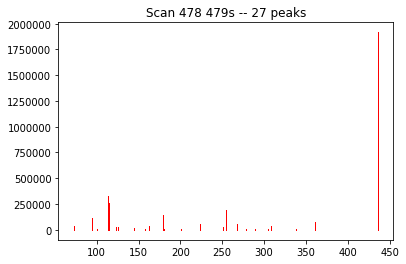

72.3482880257438 31854.5443638667
94.14685868934455 115165.30666063767
100.72722781102658 8677.318445526229
113.58458890898007 327444.9941346989
114.89023591309291 255523.21413470042
123.56478771496195 29852.056125415478
126.07483680809935 28212.170831883705
127.40585712393303 -1651.9798318605615
144.58151953071285 17331.07268669185
153.68360776854342 1921.969561253993
157.3986078589969 4419.184854192414
161.96386130822108 31947.673394037996
166.53675108490216 1583.489687510279
178.84914515730142 143663.84689319934
180.43127324164132 5524.163917137283
200.38522453851212 5512.378286032851
223.06035915640163 59424.72594813779
250.44497389665554 27657.41889091889
254.33014588303743 192995.2443432358
268.19005958268644 54697.88749444914
278.666340108782 3089.822298059992
289.1126706860337 3246.0827443722806
305.00237634044254 5884.071469016226
308.30050377891905 34938.61005408784
338.02120783902916 6768.263639556384
360.9824215855626 75249.65405061598
436.1155370352938 1916947.9167833326


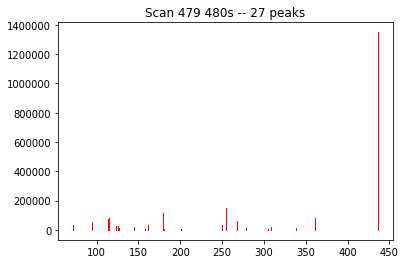

72.34832593577856 35187.370301538875
94.14757973566931 52875.37427005453
100.7272816290579 2412.732089368805
113.58461843181745 76968.22294716943
114.89038772140555 83525.21182421455
123.56467448135396 29570.607110843557
126.07560612537222 25972.550323876858
127.40643737288639 15626.46870389953
144.58151953071285 19354.39952676463
153.68355848210703 2048.9703597707735
157.3985714006488 4223.990733403073
161.96381837754424 32639.93527964052
166.53678031541097 2446.726556089493
178.84918603818286 113868.37745147475
180.43142019627138 8815.483722078277
200.38517421898638 4739.135350582084
223.06055700131654 123.19463635256778
250.44462250229515 35382.193292265816
254.33120335450604 146608.7108506416
268.1899119364938 64187.32185550481
278.66672344964456 10881.195793004934
289.11250578744455 1460.2165907651818
305.0020154045104 7771.178610073267
308.30004228283264 20308.519577842708
338.02065036681796 14136.18184946045
360.98270736146065 78885.27485576426
436.11629612213807 1349355.5139059

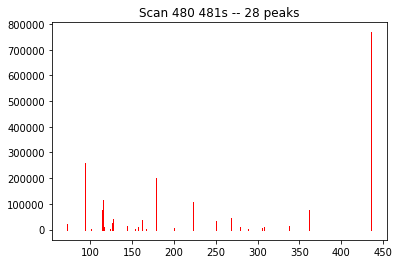

72.34834295659466 19847.973063736506
94.14746653146618 260083.41133345585
95.62509545760771 -1603.580149515971
100.72723256542687 2317.430316214189
113.58456470368718 76820.37256821696
114.89006658258026 113891.86776594652
116.7535282138355 8088.992525875415
123.56412360852212 3844.8462971618137
126.07608370875406 25073.674442209423
127.40627328561753 41475.339031018804
144.58153120483632 14559.169734236744
153.68351189429103 1766.4476722786565
157.39853228836344 7817.4316796020685
161.96399344205267 35838.25149359718
166.53679140770004 2830.8505803469793
178.84902224783173 201250.3482451599
180.43095989348595 -360.5596055599926
200.3851719261554 4444.986671629183
223.06012833397497 107261.55673237407
250.44461490833822 32609.74527989093
268.189958242824 45434.20449841772
278.66684903638526 9101.135981188178
289.11177611258097 225.44665216418795
305.001969506594 5867.553615465819
308.2999348265721 8566.590650161163
338.02083133693634 12085.851172309001
360.98269246613876 76172.20053832

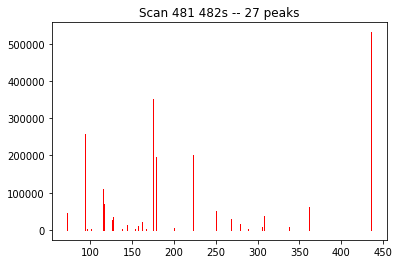

72.34795376751295 44095.720074514276
94.14754018611941 258870.83662335607
95.62414363443717 1930.1116781425394
100.72739795079382 3184.9858830379053
114.89045148606878 108884.25615311433
116.75385693532215 69246.31588224431
126.07495733102938 25677.360412267284
127.40602760926481 35420.1413734227
138.1914098080029 1848.815164927375
144.58149591980975 12929.078480248212
153.68360142062858 1706.5547070209443
157.39848322473327 10319.545280679793
161.96383240395332 21720.095017565593
166.53676360178588 2701.9493584593665
175.61072583171523 351608.2122504953
178.84907233862802 196716.73278860396
200.3851600976368 4908.2373675078325
223.0598662862384 201310.24424929946
250.44464214295365 51587.58769351169
268.1899547881531 30392.080184528975
278.6663900071182 14766.401846239001
289.1134161591301 3547.0712983666426
305.0021487831533 6490.420696305965
308.300250540539 38209.40795223354
338.0208567184022 8787.060115639182
360.9827197716587 62390.39057556705
436.1154028966672 530758.709194036


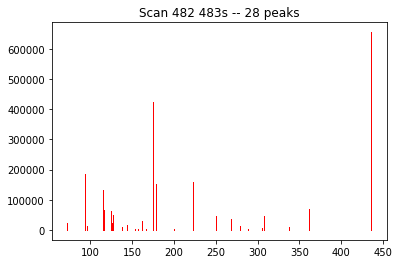

72.34791891457037 21630.04979006262
94.14730719073451 184480.26595931206
95.62507818577232 12374.885032675951
100.72720672324466 915.1999395654478
114.89047605738764 130840.3013942225
116.75413573259272 65304.80459179015
124.83607684984808 63355.428499188056
126.07472619813528 23904.122495085398
127.4062184831853 50938.53064759521
138.1909909074617 10172.239604062866
144.58151953071285 16876.218533030325
153.68363755035787 1758.8282032002187
157.39859510091904 3805.1308971881303
161.96377098074848 28472.706461615773
166.536735353671 2722.1392658753834
175.6097607326788 423483.39017166215
178.84945850902992 151575.96605073207
200.38518947777536 3586.8992174994955
223.06038717693067 158516.5810697233
250.44461780266178 46278.39039677008
268.189930236602 35124.3349504665
278.66657186308254 12288.64044362154
289.1136662737194 2742.1978427820736
305.00200123644174 6293.043750730537
308.30018661299647 44543.885585229174
338.02088132935216 8756.790212662994
360.9827932129164 70852.14320992783

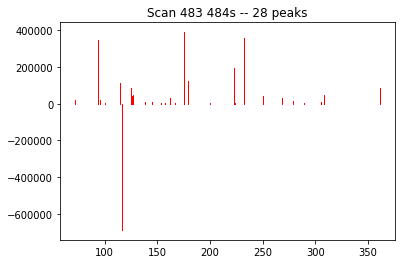

72.3479678994468 18176.76271078835
94.14746054061165 345941.48237873876
95.62501355220672 18326.983815787436
100.72742711028927 3220.9551445229636
114.89048883851675 113404.29919886956
116.75268595589846 -686434.086417868
124.83545134751834 87145.00104506548
126.07529942256453 44132.75398577292
127.40617556113465 49634.244416914014
138.19073782457502 6963.673764765418
144.58151608442628 11034.086307233865
153.68352975187184 1534.1066007569914
157.39852179461883 6133.311732851684
161.96396888715165 28963.39552466527
166.53674692212363 3577.6694207962537
175.60980230976065 388641.33563021355
178.8491669462722 123714.48252219993
200.38518947777536 4264.160808611707
223.06003011401663 194767.92175708982
223.27147063003306 1394.127843337939
232.61144753619695 358676.2467106136
250.4445696296894 41056.04038820907
268.19001078287994 31118.90862025059
278.6666322590425 17127.727357104573
289.114386044355 1676.5587901398346
305.0022352972104 7728.458453154829
308.30029656527324 47163.9694570841

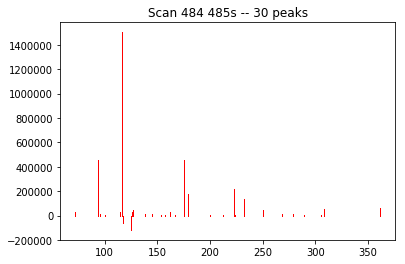

72.34780796778854 27278.051209397585
94.14746924013659 453168.83821153984
95.62514880335901 13645.826835679762
100.7274516224001 3518.6092088956743
114.89033283116623 31493.774065050493
116.75460294908682 1501973.7314643739
117.43283256484285 -60573.958465867676
124.83519290648941 -117793.6693732878
126.07520677057471 30195.058576743533
127.40625885708455 47669.355575418944
138.1914499427973 13701.133741811462
144.58149207374336 12019.43786315639
153.68358503365803 1719.2665232463658
157.3988584251076 5599.165138602064
161.9640486796931 32187.022363614116
166.53669223844275 863.5870844050564
175.60969296368197 456124.44073666463
178.84911784317 173824.4382822378
200.38518947777536 3367.6058893930312
212.1514594007101 2045.4202071204693
223.05993391991737 213716.67919109925
223.27137786729315 3649.717379883914
232.6117108251068 138976.6835930219
250.44468353745117 48826.87021359138
268.18994221898987 16716.019531958013
278.66678354331316 13104.445767959682
289.1144156347668 2006.2791106

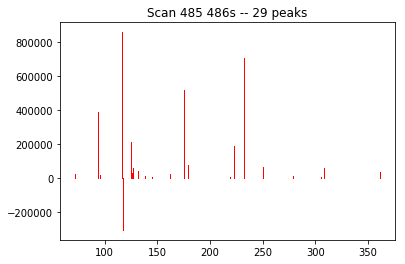

72.34789992969837 25390.03576596867
94.14743549884041 389503.0112404612
95.62484321155439 22087.060426153246
100.72748347299705 178.58806988767105
116.75415742015375 859910.1508397831
117.43294981715125 -303764.7570762044
124.83579649878234 211778.00287044115
126.0754092760697 30470.980177650355
127.40640142462603 60169.86768071196
132.04296794582152 44936.542741434794
138.19134561593683 16017.232927187477
144.58157098189506 9984.530129092058
153.68356423143848 1946.843375889177
157.3990057344149 3827.068632533685
161.96385179707454 23326.84408800667
166.53676792988915 2628.142238333443
175.60947517517045 522243.21233871666
178.84920941278162 77175.71248343188
200.38518947777536 3627.048139278304
212.15163181640582 1544.4342513708123
218.76917800798188 7337.50254684074
223.0602919208407 187360.79046661197
223.2715101033321 4586.0791555471
232.61074318343833 706739.3147716146
250.4446617517953 65894.33968253944
278.6668698120856 15955.802815154993
305.00261854395444 4852.41651519548
308

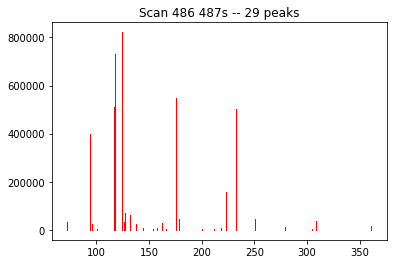

72.34767949775375 32135.534119050735
94.14748468107733 398092.3376076598
95.62479470338086 22820.89716607745
100.72721134652066 3983.27610768935
116.75500334835685 508917.52551402204
117.43246897682093 732179.8577827679
124.83613353291337 821381.4365895769
126.07484481280025 31691.248358681554
127.4061087052157 69895.45840726595
132.03718541020592 63689.17658347725
138.19098291338523 23994.24728553253
144.58151953071285 9459.145028138457
153.68356423143848 1867.3809202559041
157.39863574751908 8478.497758359392
161.96388106542085 27767.61458478114
166.53675989757076 2703.705980571881
175.6102357205933 549841.6109645137
178.84928376491615 43343.09712215437
200.38518947777536 3224.937999813618
212.15111346127685 3005.2476814895085
218.76918414586925 7923.1476503039
223.05996800184835 157792.62584590047
223.2715470793967 3116.286363326958
232.6115968997146 504224.0730297153
250.44474944657972 45850.195712305205
278.66680620605496 10754.028050695008
305.002288929449 3531.5990975411287
308.

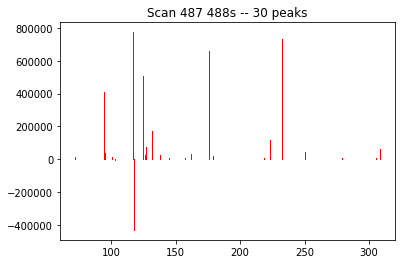

72.34857460207225 15539.779671152352
94.14717636481657 406506.69795813627
95.62479410242499 34485.87557864512
100.72743730865122 12117.481383628025
102.77337951288146 -5967.046667395078
116.75488367158042 774090.734962912
117.13288934241399 8787.20474960458
117.43318154506971 -431876.64548426564
124.83534398025776 508241.40189383813
126.07494587790515 27710.66889719949
127.40599813428092 75352.67067559087
132.0426267320839 172737.37285136044
138.1907861844368 26717.87166430125
144.58149977556954 8559.122323532842
153.68354200577866 1956.3937003771796
157.39871411340656 7508.58770136217
161.96385657298262 29472.869692950684
166.5367718652484 2374.6899530874425
175.60989426517372 660498.8633817715
178.8491314445719 17593.42362175538
200.38519401716613 2713.4475536586006
212.15140743751715 1976.0455248846954
218.7691249199198 4646.055963704904
223.06013664215794 117236.89806350635
223.27144299890725 4430.390620900551
232.61163379108524 732759.7740360188
250.4448215921542 44751.23303886213

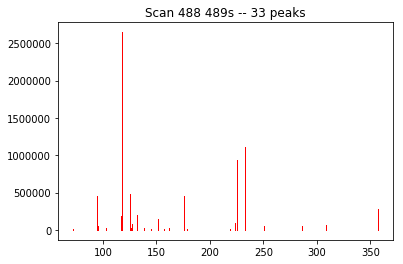

72.34768673804119 15648.924247169714
94.14761269387526 453516.996370021
95.62510009605482 53274.302650660924
100.7272143243904 4506.044428490952
102.77315041218853 22117.298212998587
116.75546409426534 180402.75856894505
117.13831995732734 33508.39265084386
117.43151799244174 2648383.2433838206
124.83499987789695 482758.6806142642
126.07490944806344 18987.5421713192
127.40640979175231 76243.21441816939
132.04418740988686 196157.57226551473
138.1919081653017 19725.12495385371
144.5814389027411 8874.034942803124
151.26915902809654 139931.59191171965
153.68361001146874 2384.436526656729
157.3986411461952 6625.785921341479
161.96398306333901 24515.275049378444
166.53677528633804 4111.881740472792
175.611618538614 449686.25633211277
178.84950981651 11798.917617640354
200.38520320920767 2836.8461021296125
212.15162174196337 2448.950145246977
218.76926735974928 10493.672830371357
223.0600517891274 86798.88069509246
223.27146277841834 8759.613551166363
225.39289092851521 931730.2297531146
232.

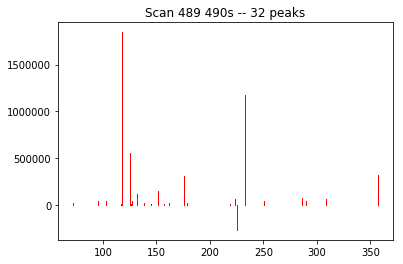

72.34796405365923 17446.072994738235
95.62515979397733 46080.239546058765
100.72723897509962 -3333.6050666807773
102.7729443251246 38953.92351620081
117.13659016098063 13089.045215050382
117.43102822092244 1844620.28924962
124.83592920120677 554580.3025761066
126.07493401938224 12827.39342276235
127.40606763085128 43200.1207024643
132.04004280503224 118816.47965053476
138.1900357980603 20388.12492950662
144.58165045550743 8160.5471046364855
151.26968529588692 145892.0008575824
153.68356838117035 1835.8388325569767
157.39856998115013 8751.240377580567
161.96382409898126 25070.733638159105
166.53667071909402 1277.3093435992914
175.60916856192452 313803.26716573176
178.84981137360614 18242.413373489602
200.38516443177338 2583.5157248614596
212.15183093503916 1976.6977761485673
218.76929792623324 10369.336321867499
223.0600497215823 69312.412401789
223.27157524736768 11456.08011185436
225.39232384285074 -264462.302956118
232.61096702811975 1174273.5562830332
250.44454600798335 40877.247869

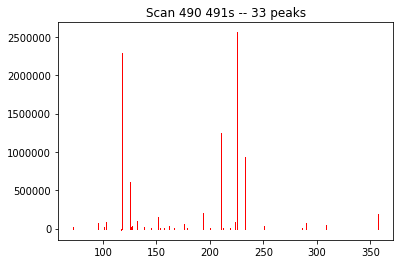

72.34813466206244 24192.359245105916
95.62500525443741 69662.36543184653
100.72710735853272 21459.979217333384
102.77319086366631 79617.41681013104
117.13692870780629 -17962.02885001993
117.43187402047974 2293050.6634325837
124.83608783359202 608004.8848553888
126.07500211507063 22748.61950042595
127.40600263532782 36600.972999472346
132.0384105156679 94366.04546230704
138.19079270915904 22134.413341756448
144.58153033889212 8320.51906835482
151.26923107460698 146925.14943622955
153.68354807495257 1951.70620510828
157.39864369510664 9423.247571640857
161.96383521871567 29007.80010022559
166.536738379619 3022.6683729595447
175.6098005900045 55016.219211759235
178.84899540737032 1828.033584672012
193.76774847821306 203259.56284918127
200.38518947777536 2408.1201585051194
210.54479365442734 1249206.9606553987
212.1511416820801 2937.791219340777
218.76920057464577 13331.140659289298
223.05982804425943 90871.22531808967
223.27161225332324 9880.406960639135
225.3923200681298 2560997.74075552

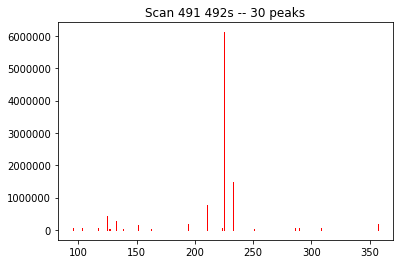

95.62498568439048 52716.835459191476
100.72732411539941 344.6866716217523
102.773154125009 56773.24506833011
117.13546824463037 52686.60405118936
124.83542108994982 444636.2582979516
126.0746524085734 30263.57504936775
127.4061291712847 17549.838323174004
132.0412321962949 263048.6552426345
138.19089099443516 23842.103266586673
144.58159913090603 6472.0021295341585
151.26923107460698 154713.45877495757
153.68353605069015 2106.1723677719856
157.3984321819484 7297.202086539548
161.9638853120341 25181.074163129124
166.53671446302184 3317.1770481835874
178.8491733057615 1965.0559901525294
193.76455144996623 177925.65655670824
200.38519236203226 1834.2222287102384
210.54373887722247 785295.1311458412
212.15145399897122 3377.291036315465
218.76934685835184 9396.88853476367
223.06030745822792 48681.06155733296
223.27149000306315 13840.832358385007
225.39224162721692 6114974.623286821
232.61063174802985 1493354.0162956587
250.44482681399052 36790.80585677429
286.35921667799335 64768.5312032529

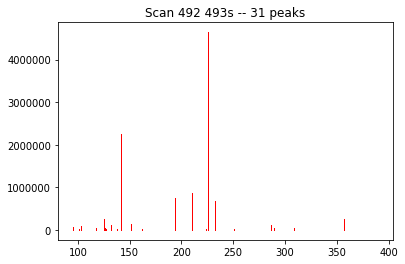

95.62516842303319 63275.30119325394
100.72716318946273 24709.633145653723
102.77329119827749 101493.81114394632
117.13757351252093 47461.41909375069
124.83538296137992 246983.6908919045
126.07467835850963 54204.34801014393
127.40595717205203 16639.24347430351
131.86982517081626 69542.5613291281
132.03987358404288 118177.86903083892
138.1901423840099 21553.057882863814
141.78655489440177 2247615.2710171095
144.58158047502312 5427.348185194824
151.26907018888656 133609.75242115487
153.68356423143848 1505.9930120767335
157.3984960761225 9048.97780069323
161.9638668983704 18254.3176019711
166.5367673974729 2817.87185091307
193.76522650704143 740687.8768947324
200.38520419055087 1894.027351432184
210.54344421361796 861895.2824103117
212.15194309519194 3181.885222870347
218.76906818131644 1422.0509329392753
223.27160254085476 12973.341361341689
225.39225391287633 4643291.271880832
232.61088539753493 686289.896686857
250.44476262286761 29362.759478524116
286.35915896101415 119473.46902886574


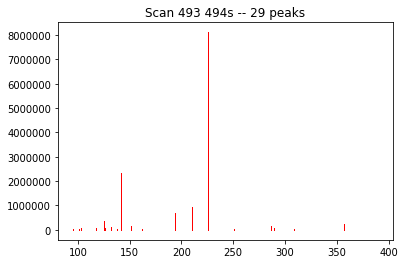

95.62495077850173 40765.08507474987
100.72722522335467 16030.292978307103
102.77309700422126 77730.40148927036
117.1357878708743 95485.42860123172
124.83494006632813 365404.8505088235
126.07458007323345 64746.59584554293
131.86988242706016 71721.51857404519
132.04124606771546 118532.74198060026
138.1912956999072 16053.732272722416
141.78649371240817 2342652.30964128
144.58156841273933 4579.446815771903
151.26952674586093 157445.60872201787
153.68356922440069 2166.8403689108727
157.39863809284594 7867.1227767772525
161.9639498284995 41825.564877941906
166.536776663023 1855.0326125393149
193.76493928277714 686798.8409168365
200.38516438491098 1823.2303863980605
210.54310021515258 928132.0952308178
212.15200943775278 3189.756268239859
218.7690861893285 -2579.4298044362163
223.27151313337137 13532.59440944495
225.39197811379228 8112411.96321192
250.4446312835125 20069.063630825007
286.35915896101415 159752.09336773425
289.6562827869612 96577.05935064846
308.3005271897992 55559.168172899896

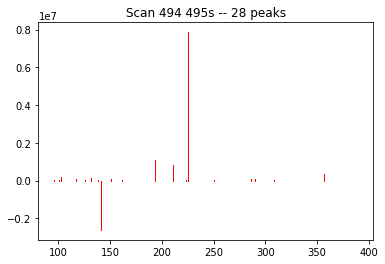

95.624803231791 49095.598125912584
100.7272375686532 11780.282932360089
102.77329181666111 216959.94502854705
117.13644273509017 87357.186879657
126.07466960004643 49666.45772407455
131.86973928744862 46071.31780232332
132.03690117665488 156417.3055624852
138.19138482941005 20282.139370911307
141.7866557992131 -2609568.47237938
144.58159582465782 6819.214193914756
151.26931176624086 104093.96241404388
153.68357854559127 2255.0568320366383
157.39871180680242 7524.825203497218
161.96383415180813 22935.323763382527
166.53678794480496 3145.219645897896
193.7660583222041 1101260.5055341455
200.38518387295915 1699.0578144344736
210.5434649381046 846262.6889623317
212.15184855165785 2305.5277971241394
218.76910419734057 -6580.910541811708
223.27149355038082 16126.133673767745
225.39259234502484 7862802.997263235
250.44462797564506 17978.642894079254
286.359220006627 61982.32379143721
289.6557866380108 110888.2392749989
308.3001441717149 57107.299554477926
356.8926273787892 335884.31001492456


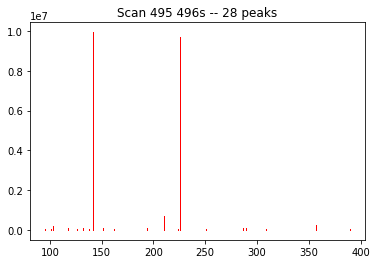

95.62515311249118 30971.108142083496
100.72718914047576 25287.74435276737
102.77332396159838 206551.74042014568
117.1366841716258 72021.21669711161
126.07526149695306 24662.066667995743
131.86963977941318 95660.61430908236
132.03875708088285 56748.98105522909
138.19138482941005 22669.166993158797
141.7865767363029 9950034.240036579
144.58156120921498 6686.395184364427
151.26911424146337 102455.74865853183
153.6835381499032 2055.5862706409616
157.39855686729777 8991.866928514502
161.96386091505693 22253.9410694174
166.53678941601996 3364.0358418599653
193.7646678879945 88403.54585100144
200.3852068943829 1427.0267114833111
210.5447409146899 678217.8149008359
212.15180911040693 4980.495143379238
218.76912220535263 -10582.3912791872
223.27153052644545 13772.923548271829
225.39244034038379 9686517.851978604
250.4445347210133 22241.953165380823
286.3590364194878 92767.0165964334
289.6561196719985 96695.3087205767
308.3002795519731 45305.6917679299
356.8930365670442 259606.10699098223
389.47

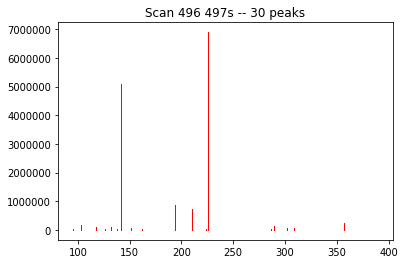

95.625176988442 32603.747501281683
100.7272899237223 12505.438932263334
102.77326463504704 187967.52384174726
117.13647783382643 96484.29508073021
126.0744034737553 25598.464937646837
131.8697169903734 85050.63853569067
132.0372507590727 41980.658427746115
138.19198183479622 19027.902381473483
141.78670485896163 5080610.02585647
144.5816923903932 4039.037122707635
151.26971727114955 71155.6820300502
153.68357183863884 1747.0968151025982
157.3984547703087 7526.100613724105
161.96395537893676 23872.413854973383
166.53681337016283 3672.555073565906
193.7648784388735 885823.9733846779
200.3852186319129 1604.5214636149508
210.5450840497918 726610.175442993
212.15158915528121 3727.8192918908007
218.7689291400431 11627.026909166345
223.0690258552845 12920.154472335753
223.27140973952032 16553.520294463324
225.3926842522375 6899123.446585915
250.44482116944727 12316.483641446372
286.3591476252776 21161.680658142872
289.6561319973531 127905.38714792852
301.9935387276653 57155.47561241122
308.30

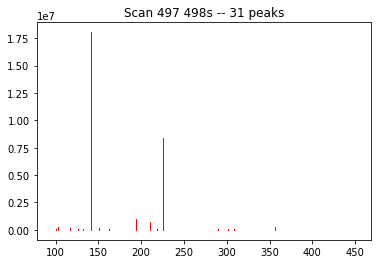

95.62513229462523 18366.56080835685
100.72712880256684 25275.863972322313
102.77344754129479 270517.2571361511
117.13566777781564 117103.69971450178
126.074107665244 29095.87033982978
131.86967210857117 95523.45311261677
132.03672116986445 41737.51899117547
138.19037525457153 15401.324767476272
141.78651728555778 18047925.85293959
144.58171575760528 3814.407814695719
151.26940837847548 170193.48535734825
153.68354897264948 2138.0150013747398
157.3986146393528 7508.548624041442
161.9641028068506 29889.75596581237
166.53673919498905 2865.850011862281
193.7648661135181 955226.4066583037
200.38518947777536 1238.6996547776314
210.54397443173758 681023.6369600653
212.15169973589622 2426.9473364740848
218.76916409864265 29158.592494112872
223.06962931021914 -14578.065598061496
223.27153443527416 19165.46939008434
225.39269659753603 8383875.6299242405
250.44465609925857 11657.722111131958
286.3591722759876 14885.573747842664
289.65640397576317 55126.26977769994
301.9934782866614 97541.92919375

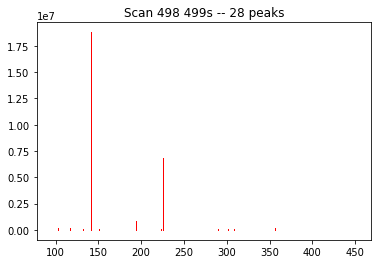

95.62505093141122 11425.071361632048
100.72714116784019 13996.426732900636
102.77324287493954 158019.19225652658
117.13512868186521 150624.48014382273
126.07465695720869 24196.029964914254
131.86962924680432 104104.78052447327
132.0361915806562 41494.37955460482
138.19097699269147 11469.712430098289
141.78647432034376 18790837.02279963
144.5815823270782 4352.433899847576
151.269505732811 106803.70238253404
153.68354897264948 1911.8751325647404
157.39854162052512 7070.868414328244
161.96371459781153 16562.969889149692
166.5368051275495 3279.2275510812324
193.76432078537283 881639.3639936612
200.38518405186662 1094.6401524746852
212.15164290614143 2115.7216207800807
218.7690886667754 -2441.0025319886167
223.067857837559 42076.89520395443
223.2714441154422 31739.52836231689
225.3928471296056 6874694.703979817
289.65565255714756 66322.2927839739
301.9934883770686 111151.22494936199
308.3001847299537 40593.97516586648
356.89271930198686 184482.49124452428
389.4734924035579 19530.46524013284

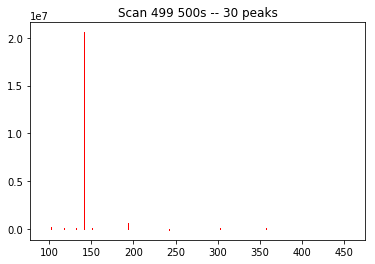

95.6251705143979 16403.161345451448
100.72706709604894 15346.137971996546
102.7735595424719 236880.4323643927
115.49449352944289 1497.5018272247057
117.13430584470738 165073.2405560492
126.07498794579253 12886.794480878149
131.86974710455985 79295.76854636414
132.03996350475256 47305.9743653286
137.95689890542428 63395.606673596325
138.190848317028 11734.838396591054
141.78655458250358 20565854.684753966
144.5817930987923 4078.114837711822
151.26947953397428 163463.68460846375
153.68354897264948 1709.9767834522343
157.39859060540152 6436.7812008619385
161.9638197590857 14344.882777096613
166.5367346014814 2525.6175301097132
193.76613876264702 629665.4003947265
200.38517491486724 1162.875407147627
212.15176721791988 3123.7071024092634
223.06870184545716 40641.75556592515
223.27146281964696 34992.20734004151
242.26906687171348 -76633.19862544964
289.6556500369525 29237.236598410298
301.99354754240596 156248.35431809776
308.30019053245843 55130.70734680179
356.61518847213523 112685.333618

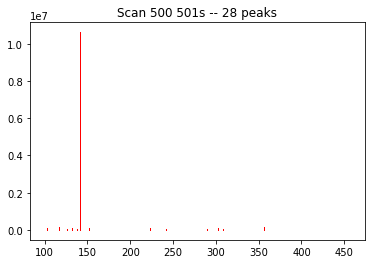

100.72722921168423 14811.876197788833
102.77364239045843 122799.81673143766
115.49149685720194 1305.1892460590075
117.13701294769454 159801.62886598316
126.07518567207318 24481.846849705904
131.86974013320105 93929.38733042275
137.95682848861972 67429.90405439737
138.19111336095082 10223.929793260391
141.78659149865192 10625132.593572557
144.58169421469827 5271.097344220388
151.26962709921665 95532.93860885501
151.55188006781475 71622.55711553004
153.6835290760259 2410.337790725816
157.39862849382428 7588.671912407277
161.9638803135976 17879.023457039606
166.53674059472178 2325.5645510647328
200.38521566421394 994.6692931673051
223.06872004397766 97847.36777959931
223.27146281964696 33685.20988304216
242.26904287472155 75599.04534267387
249.41680585202283 12979.247720967975
289.65599132679745 32776.82623232948
301.9935595761512 121512.56256667661
308.3003469284045 41620.7411605428
356.61522538856025 132116.70429089133
389.4727271460705 15547.521623127463
451.1979871597891 9335.25457586

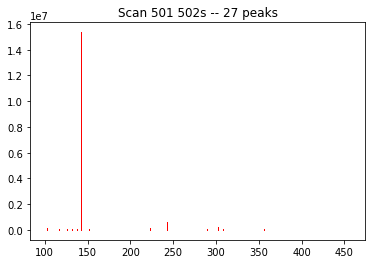

100.72730885493615 10884.68207069236
102.77371622330841 156713.34107019118
115.49307030384054 5916.076367948012
117.13464694646613 92533.4250218568
126.07567828834601 33453.160011075626
131.8696615619879 69595.6001102051
137.95675806343897 64285.326901206754
138.1919357836845 14997.32368884628
141.78662607188767 15356463.499782922
144.5817249968514 4664.032397344488
151.2696023886271 65722.84428077588
151.55150744789108 84713.44019359784
153.68359951180975 1681.8289511765443
157.3981022428853 8252.235834088353
161.96386131136967 19001.629138657274
166.53673132570256 2994.112167732584
200.38518198039617 923.5941936178671
223.06873823748415 135371.6985659425
223.27144311923092 34748.73202265618
242.26857348874617 586640.7413853543
249.4174620252327 25067.236962197727
289.65626270380636 39534.02049686946
301.99355952467255 205184.35079881107
308.3003591746236 39899.01199597604
356.6150691465583 71784.85349722057
451.198135183612 9041.31408178171
456.30816013613185 24045.109402007507


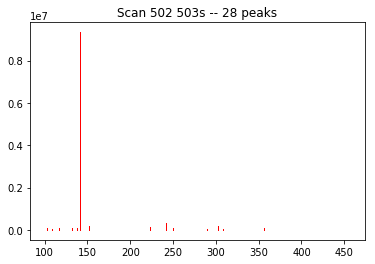

100.7271215258792 3727.7333060881447
102.77362772176981 109439.74134720427
108.7212038894345 56979.367202368805
115.49626200549471 6382.139256160364
117.13736073650847 73258.77374021246
126.07455328820917 13937.062751937052
131.86958790733468 68428.74620167904
137.9569602757594 79088.71632502241
138.18985709427795 6200.014243034562
141.78667332238984 9340662.291847618
144.58162962942015 5085.305303306614
151.2693053855693 197552.22276794008
151.55169158452503 57840.48352016406
153.68353031779316 2311.8167562826675
157.39856458334108 9157.90981533632
161.96390817991775 17652.064298850048
166.5367144402843 2239.8467964415454
200.38520473656436 753.8749236509402
223.06872592207736 142916.7257479825
223.27150021430407 42335.91641401487
242.26889029174103 326180.39099130745
249.41676055013426 71207.40156503988
289.6555697222285 34450.95637769308
301.9934741157988 188557.51009230598
308.3003518723164 47342.528518806466
356.6151799426318 109319.8272944677
451.19775070263455 8022.94728577521
4

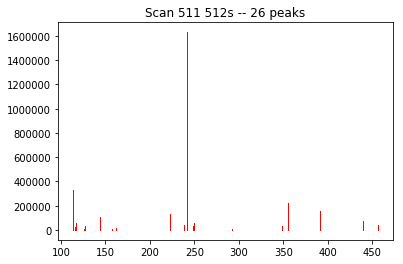

114.11139683201573 328955.7121857497
115.49318083885488 11985.313151003496
116.29304856560621 28109.84829512305
117.13706381746134 55548.10879008215
126.07437367380227 6921.19591188369
126.99339177359451 32864.20386660307
135.12395839269317 2521.315150677321
144.49816071541713 105752.17148193995
153.68351278135137 1761.5853513025422
157.39892497780528 4399.302090072249
161.9639704304161 11893.338026598218
166.53682992147085 2389.292336466194
200.3851909700703 465.509267278827
223.06889491711027 134902.66115889337
223.27147807843693 2869.653013695424
238.57747196968842 39448.35738113995
242.26887955490866 1630526.9715472828
248.14292811424227 33773.23592767434
249.41677603650055 59870.288551959275
291.8822159787859 5821.7385911582105
348.31356263199865 34161.11462814146
355.6630462523467 220197.65659800256
390.8968996018372 607.2229459222698
391.64534048949014 153810.32142222987
440.2182104796394 77633.4286991538
456.3071653068255 44400.91501869694


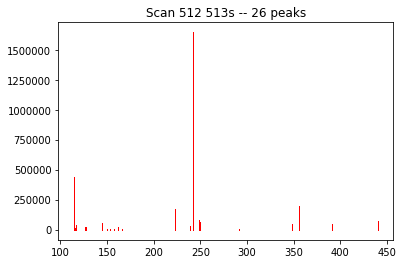

114.1112239978353 435823.24352793954
115.4956931818485 13635.290003237116
116.29302332756914 19060.570871235574
117.13773823907736 40497.3145499507
126.07451218948397 19675.19564319786
126.99427444673421 18555.596511789437
135.12399535382923 -3001.1083702159517
144.49819304635054 51321.856079081736
149.49292636407264 715.2933542889281
153.6834767936407 1473.333960526579
157.3978974592445 3779.1112800784604
161.9638231515569 19279.383960994182
166.53677409133118 2315.043282617704
200.3852302520676 304.21744988091126
223.06899879691437 174441.7647064769
238.57820954573054 33407.79402405036
242.2688580485112 1646161.8059964061
248.14286379546382 77647.26745403529
249.41718995811704 60505.5759623052
291.8828573424488 5599.028919132223
348.3133532700826 46097.56545504439
355.66302803609346 199274.95891238662
390.897133405863 416.2177485733345
391.6447925399658 45226.32779635114
440.2181491501008 74947.65855233649
440.42710061600985 13371.5276917195


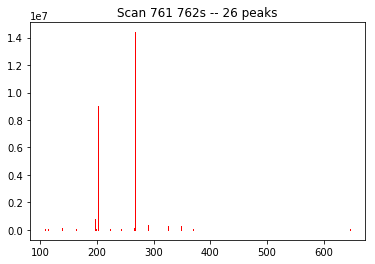

109.55954546908437 91943.1037854007
114.61249145451697 56105.404387056224
115.00144103419082 578.7586763618712
139.23394109839958 161845.0927295222
147.73241778716417 13834.679582690114
162.6771953124243 37067.05374199092
164.86790279774354 3449.589346719938
171.11603918380928 2145.0007649273075
178.24612752341824 7773.64277230843
179.83111992069146 7183.446581155706
195.5209793888624 8541.87198624472
197.3952422202154 760077.7668054546
198.6498714612841 31452.481678714506
201.67605095619425 9035365.790224949
223.39489252586924 80076.98216491888
242.2342715344111 56821.16843441521
265.86573156759425 147126.81629284812
266.65339884630373 14385311.556642001
290.3513570797041 376056.32211225125
295.8786369908226 3838.376130623021
302.48716941161683 3323.999915692128
325.74447372287887 316617.53369026835
348.1504320368247 260511.64116922294
369.1642436712129 75845.0230924898
465.197070915465 6452.6499023498445
645.8459169008689 101023.77453445071


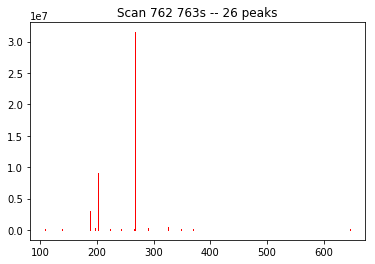

109.55950837316216 96803.98990947544
114.61245251092626 56056.4722042684
115.00156421851831 539.2581759991466
139.23398728609266 203036.185822273
147.73233226753754 12414.734214085067
162.67726878973974 38517.125927170535
164.86745431358105 2484.1942401053752
171.11603766787803 2281.5554419076657
178.24616129010178 5375.492685720701
179.83090795584067 4327.5230514367295
187.29258480335648 2935558.6145994277
195.5207106541071 37190.558793126445
197.40131223624485 243109.70329554062
198.64980246502648 37200.97581573811
201.67602634524425 9075355.583318131
223.39494602793445 98700.78657419368
242.2337238632325 96800.92249295994
265.86580276634703 73596.64052548974
266.6533485902909 31487996.30935392
290.35121255929164 347787.13213721785
295.88021625545423 7656.295671739784
325.74452693837685 489279.47029939585
348.1502013668563 204989.76709739366
369.1638065562154 122767.8461414989
465.196951706176 5191.961937166544
645.8458091031071 79785.92881596358


In [34]:
def plot_scan(scan):
    plt.figure()
    for i in range(scan.num_peaks):
        x1 = scan.mzs[i]
        x2 = scan.mzs[i]
        y1 = 0
        y2 = scan.intensities[i]
        a=[[x1,y1],[x2,y2]]
        plt.plot(*zip(*a), marker='', color='r', ls='-', lw=1)
    plt.title('Scan {0} {1}s -- {2} peaks'.format(scan.scan_id, scan.rt, scan.num_peaks))
    plt.show()    

mass_spec = IndependentMassSpectrometer(column, scan_times, scan_levels, isolation_windows)
selected = None
for scan in mass_spec:
    if scan.num_peaks > 25:
        plot_scan(scan)
        for mz, intensity in zip(scan.mzs, scan.intensities):
            print(mz, intensity)

### Generates Synthetic data

We want a notebook that does the following:
1. create a list of chemical
2. create a new mass spec object, takes chemicals
3. create a new controller, takes mass spec
4. write mzml files

In [ ]:
# chrom = FunctionalChromatogram("normal", [0,1])
# formula = Formula("hg",100)
# isotopes = Isotopes(formula,[0.8,0.2],["Mono","1C13"])
# aducts = Aducts(formula,["M+H","M+ACN"],[0.9,0.1])
# chem = KnownChemical(formula,isotopes,aducts,100, 10000, chrom, None)
# print(chem.formula)
# print(chem.isotopes)
# print(chem.aducts)